In [2]:
%autoreload 2

In [3]:
from collections import defaultdict
from argparse import Namespace
import copy
import gzip
import itertools
import os
import pickle
import sys
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *

In [4]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


In [5]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [6]:
evo_sampler = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_27_1', 'samples', 'evo_sampler_microbial_ga'))

2023-04-27 21:01:34 DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-04-27 21:01:34 DEBUG    findfont: score(FontEntry(fname='/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05
2023-04-27 21:01:34 DEBUG    findfont: score(FontEntry(fname='/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-04-27 21:01:34 DEBUG    findfont: score(FontEntry(fname='/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', va

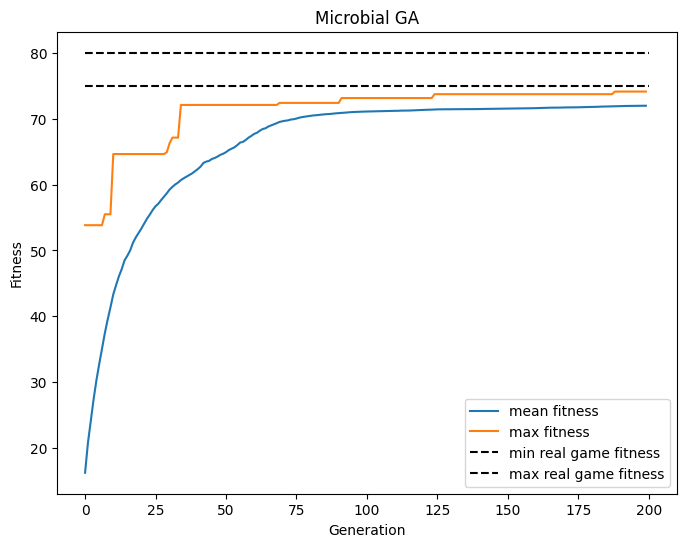

In [14]:
def plot_sampler_fitness_trajectory(evo: PopulationBasedSampler, title: typing.Optional[str] = None, figsize: typing.Tuple[int, int] = (8, 6),
                                    min_real_game_fitness: float =  74.9304, max_real_game_fitness: float = 80.0098):
    plt.figure(figsize=figsize)

    plt.plot(evo.mean_fitness_history, label='mean fitness')
    plt.plot(evo.best_fitness_history, label='max fitness')

    plt.hlines(min_real_game_fitness, 0, len(evo.mean_fitness_history), label='min real game fitness', color='black', ls='--')
    plt.hlines(max_real_game_fitness, 0, len(evo.mean_fitness_history), label='max real game fitness', color='black', ls='--')

    if title is not None:
        plt.title(title)

    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend(loc='best')

    plt.show()


plot_sampler_fitness_trajectory(evo_sampler, 'Microbial GA')

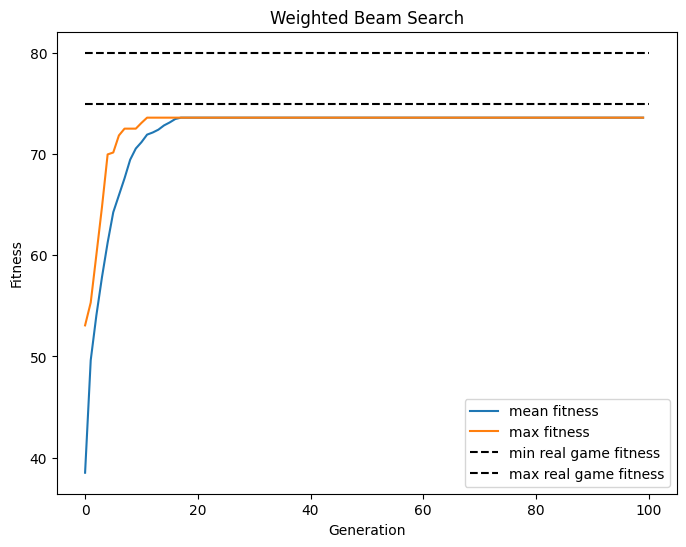

In [15]:
beam_sampler = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_27', 'samples', 'evo_sampler_weighted_beam'))
plot_sampler_fitness_trajectory(beam_sampler, 'Weighted Beam Search')

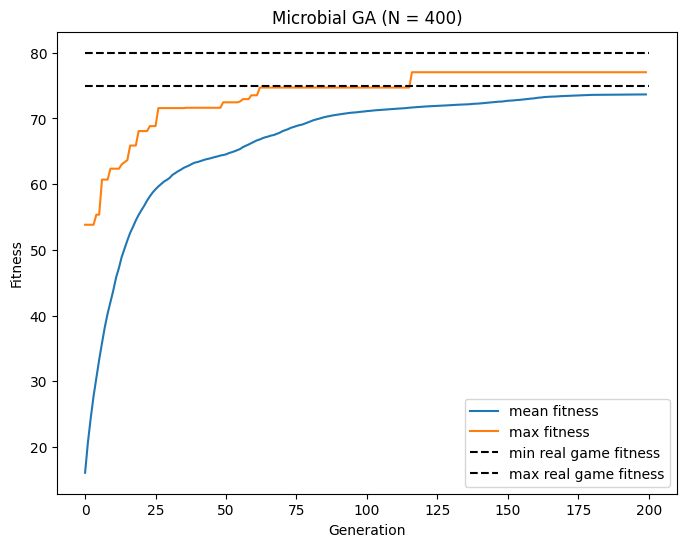

In [16]:
evo_sampler_pop_400 = typing.cast(PopulationBasedSampler, utils.load_data('2023_04_27_2', 'samples', 'evo_sampler_microbial_ga'))
plot_sampler_fitness_trajectory(evo_sampler_pop_400, 'Microbial GA (N = 400)')

In [7]:
[t[0] for t in game_asts[0][3:-1]]

['(:setup', '(:constraints', '(:terminal', '(:scoring']